<a href="https://colab.research.google.com/github/HedersonSantos/SmartHome/blob/main/seriesTemporais_sarimax_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)

from sklearn.preprocessing import MinMaxScaler


from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # para determinar (p,q)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [7]:
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/sample_submission.csv

--2022-06-01 16:20:31--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 360467 (352K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 352.02K  --.-KB/s    in 0.04s   

2022-06-01 16:20:32 (9.41 MB/s) - ‘train.csv’ saved [360467/360467]

--2022-06-01 16:20:32--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170613 (167K) [text/plain]
Saving to: ‘tes

In [8]:
def plotaSeries(treino, teste, predito):
  if type(treino) == pd.core.series.Series:
    treino.plot(legend=True,label='Treino')
  if type(teste) == pd.core.series.Series:
    teste.plot(legend=True,label='Teste',figsize=(16,8))
  if  type(predito)==pd.core.series.Series:
    predito.plot(legend=True) 
  else:
    for p in predito.columns:
      predito[p].plot(legend=True)

In [13]:
df_treino = pd.read_csv('train.csv')
df_treino['data_hora'] = df_treino.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_treino = df_treino.sort_values(by='data_hora')
df_treino = df_treino.set_index('data_hora')
#idx = pd.date_range(start=df_treino.index.min(), end=df_treino.index.max(),  freq='0h15min')
#df_treino= df_treino.reindex(idx)
dfx = df_treino[['CO2_room','Relative_humidity_room','Lighting_room','Outdoor_relative_humidity_Sensor','Indoor_temperature_room']].resample('H').mean().iloc[1: , ]
df_treino = pd.DataFrame(dfx, columns = ['CO2_room','Relative_humidity_room','Lighting_room','Outdoor_relative_humidity_Sensor','Indoor_temperature_room'])
df_treino.fillna(method='ffill', inplace=True)

In [14]:
min(df_treino.index), max(df_treino.index)

(Timestamp('2012-03-13 12:00:00', freq='H'),
 Timestamp('2012-04-11 06:00:00', freq='H'))

In [15]:
df_treino.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 691 entries, 2012-03-13 12:00:00 to 2012-04-11 06:00:00
Freq: H
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CO2_room                          691 non-null    float64
 1   Relative_humidity_room            691 non-null    float64
 2   Lighting_room                     691 non-null    float64
 3   Outdoor_relative_humidity_Sensor  691 non-null    float64
 4   Indoor_temperature_room           691 non-null    float64
dtypes: float64(5)
memory usage: 32.4 KB


In [17]:
dfx = pd.DataFrame(df_treino).reset_index()
dfx['data'] =  dfx['data_hora'].apply(lambda x: x.strftime('%Y-%m-%d'))
dfx.groupby('data')['data_hora'].count().reset_index().sort_values('data')

,data,data_hora
0,2012-03-13,12
1,2012-03-14,24
2,2012-03-15,24
3,2012-03-16,24
4,2012-03-17,24
5,2012-03-18,24
6,2012-03-19,24
7,2012-03-20,24
8,2012-03-21,24
9,2012-03-22,24


In [22]:
df_treino = df_treino[df_treino.index.strftime('%Y-%m-%d') !="2012-03-13"]
df_treino = df_treino[df_treino.index.strftime('%Y-%m-%d') !="2012-04-11"]

In [23]:
df_treino.head(5)

,CO2_room,Relative_humidity_room,Lighting_room,Outdoor_relative_humidity_Sensor,Indoor_temperature_room
data_hora,,,,,
2012-03-14 00:00:00,224.91450,43.156650,13.232500,57.775325,19.290175
2012-03-14 01:00:00,225.70925,43.221325,13.175500,57.902000,18.657825
2012-03-14 02:00:00,226.18150,43.164000,13.423475,57.386000,18.035150
2012-03-14 03:00:00,219.42150,42.998000,13.346675,56.443300,17.412825
2012-03-14 04:00:00,214.63725,42.787325,13.179850,56.068675,16.817650


In [28]:
#dividindo a amostra em treino e teste
dfTreino = df_treino[df_treino.index < datetime(2012,4,8,0,0)]
dfTeste = df_treino[df_treino.index >= datetime(2012,4,8,0,0)]
print(dfTreino.shape, dfTeste.shape)
print(min(dfTreino.index), max(dfTreino.index))
print(min(dfTeste.index), max(dfTeste.index))

(600, 6) (72, 6)
2012-03-14 00:00:00 2012-04-07 23:00:00
2012-04-08 00:00:00 2012-04-10 23:00:00


In [38]:
scaler = MinMaxScaler()
treino_values = scaler.fit_transform(dfTreino[['Relative_humidity_room', 'CO2_room' , 'Outdoor_relative_humidity_Sensor', 'Lighting_room']])
teste_values = scaler.fit_transform(dfTeste[['Relative_humidity_room', 'CO2_room' , 'Outdoor_relative_humidity_Sensor', 'Lighting_room']])
dfTreino_tmp = pd.DataFrame(treino_values, columns = ['Relative_humidity_room', 'CO2_room' , 'Outdoor_relative_humidity_Sensor', 'Lighting_room'] )
dfTreino = dfTreino[['Indoor_temperature_room']]
for c in dfTreino_tmp.columns:
  dfTreino[c] = dfTreino_tmp[c].tolist()
 
dfTeste_tmp = pd.DataFrame(teste_values,  columns = ['Relative_humidity_room', 'CO2_room' , 'Outdoor_relative_humidity_Sensor', 'Lighting_room'])
dfTeste = dfTeste[['Indoor_temperature_room']]
for c in dfTeste_tmp.columns:
  dfTeste[c] = dfTeste_tmp[c].tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [39]:
dfTreino.head(3)

,Indoor_temperature_room,Relative_humidity_room,CO2_room,Outdoor_relative_humidity_Sensor,Lighting_room
data_hora,,,,,
2012-03-14 00:00:00,19.290175,0.406682,0.089145,0.574361,0.005741
2012-03-14 01:00:00,18.657825,0.408666,0.091149,0.576465,0.005304
2012-03-14 02:00:00,18.035150,0.406907,0.092340,0.567895,0.007205


In [45]:
stepwise_fit = auto_arima(dfTreino[['Indoor_temperature_room']], start_p=2, start_q=2,
                          max_p=2, max_q=2, m=24,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=-465.894, Time=8.88 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=967.335, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-314.710, Time=3.39 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=139.923, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=965.345, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=-363.233, Time=8.09 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=-387.306, Time=7.76 sec
 ARIMA(2,1,2)(2,0,1)[24] intercept   : AIC=-469.669, Time=38.43 sec
 ARIMA(2,1,2)(2,0,0)[24] intercept   : AIC=-421.076, Time=33.33 sec
 ARIMA(2,1,2)(2,0,2)[24] intercept   : AIC=-476.267, Time=38.88 sec
 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=-467.113, Time=32.53 sec
 ARIMA(1,1,2)(2,0,2)[24] intercept   : AIC=inf, Time=33.96 sec
 ARIMA(2,1,1)(2,0,2)[24] intercept   : AIC=inf, Time=37.75 sec
 ARIMA(1,1,1)(2,0,2)[24] intercept   : AIC=inf, Time=32.72 sec
 ARIMA(2,1,2)(2,0,2)[24]      

In [ ]:
modelo1 = SARIMAX(dfTreino['Indoor_temperature_room'],order=(2,1,2),seasonal_order=(2,0,2,24))
resultado1 = modelo1.fit()
resultado1.summary()




In [58]:
previsoes1 = resultado1.predict(start=dfTeste.index.min(), end=dfTeste.index.max(), dynamic=False, typ='levels')
dfTeste['previsoes'] = previsoes1
#previsoes1.index = dfTeste.index
#previsoes1['Indoor_temperature_room']=dfTeste['Indoor_temperature_room']

#previsoes1.head(10)

In [62]:
dfTeste.head(10)

,Indoor_temperature_room,Relative_humidity_room,CO2_room,Outdoor_relative_humidity_Sensor,Lighting_room,SARIMAX,previsoes
data_hora,,,,,,,
2012-04-08 00:00:00,17.594525,0.504637,0.192618,0.523154,0.003422,0.479561,17.642153
2012-04-08 01:00:00,17.271000,0.504980,0.185831,0.552387,0.001634,0.484838,17.279889
2012-04-08 02:00:00,16.921000,0.523487,0.236346,0.583272,0.005430,0.488900,16.909934
2012-04-08 03:00:00,16.564650,0.537929,0.262653,0.619870,0.008687,0.492935,16.542775
2012-04-08 04:00:00,16.178325,0.553984,0.383027,0.657287,0.003959,0.496721,16.184388
2012-04-08 05:00:00,15.802000,0.564656,0.484566,0.671252,0.013285,0.502228,15.824898
2012-04-08 06:00:00,15.459175,0.566565,0.550356,0.665042,0.084486,0.505698,15.486891
2012-04-08 07:00:00,15.344325,0.537145,0.414214,0.580880,0.289628,0.503689,15.269525
2012-04-08 08:00:00,15.734200,0.451473,0.271284,0.531070,0.689015,0.492529,15.339395


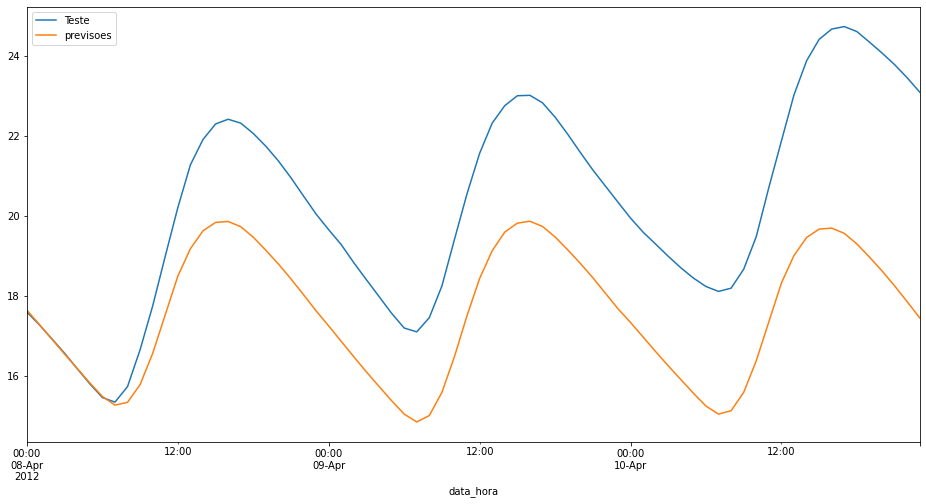

In [63]:
plotaSeries(None, dfTeste['Indoor_temperature_room'], dfTeste['previsoes'])

In [65]:
resíduos1 = resultado1.resid

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


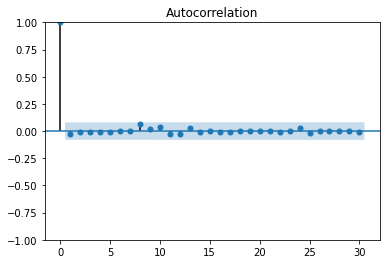

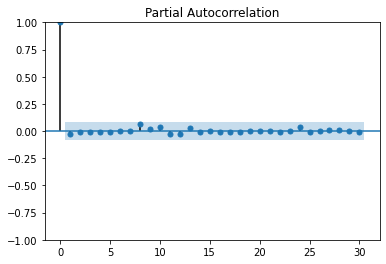

In [66]:
plot_acf(resíduos1, lags=30)
plot_pacf(resíduos1, lags=30)
plt.show()

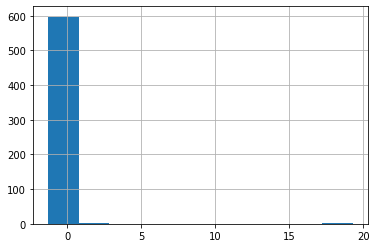

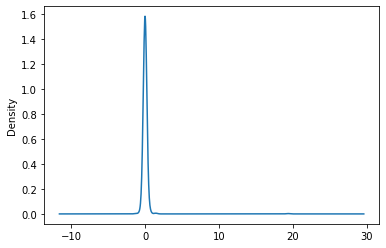

In [68]:
resíduos1.hist()

plt.show()
resíduos1.plot(kind='kde')
plt.show()